let us go with basic mining valors: jsw, lwb, kghm, cle
NOTE: inflation and dividends are not taken into account

## download transform load sample ticker for analysis

In [1]:
from transform import download_transform_load
from const import *

In [2]:
tickers = ["jsw", "lwb", "kgh", "cla"]
for ticker in tickers:
    download_transform_load(ticker, DataDownloadSource.STOOQ_PL)

INFO:root:Stock returned jsw
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned lwb
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned kgh
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database
INFO:root:Stock returned cla
INFO:root:Dataframe cleaned
INFO:root:Dataframe saved to database


## SQL data exploration

In [4]:
%load_ext sql
%sql sqlite:///SQLite.db

In [5]:
%%sql
SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///SQLite.db
Done.


KeyError: 'DEFAULT'

NOTE sql magic does not work properly, let us use sqlite3 cursor as mock of sql magic

In [2]:
import pandas as pd
import sqlite3
from pprint import pprint
def mock_sql_magic(query:str, return_data:bool=False):
    try:
        conn = sqlite3.connect("SQLite.db")
        cursor = conn.cursor()
        cursor.execute(query)
        result = cursor.fetchall()
        if not return_data:
            pprint(result)
    finally:
        conn.close()
    if return_data:
        return result

In [4]:
#check sample count
mock_sql_magic("select count(*) from jsw")
mock_sql_magic("select count(*) from lwb")
mock_sql_magic("select count(*) from kgh")
mock_sql_magic("select count(*) from cla")

[(3600,)]
[(4113,)]
[(7107,)]
[(899,)]


In [8]:
#check interlocking period
mock_sql_magic("select count(*) from cla inner join kgh on cla.date == kgh.date")

[(897,)]


In [9]:
#check basic statistic
mock_sql_magic("select avg(volume), min(volume), max(volume) from jsw")

[(534037.2415902141, 17080, 8471186)]


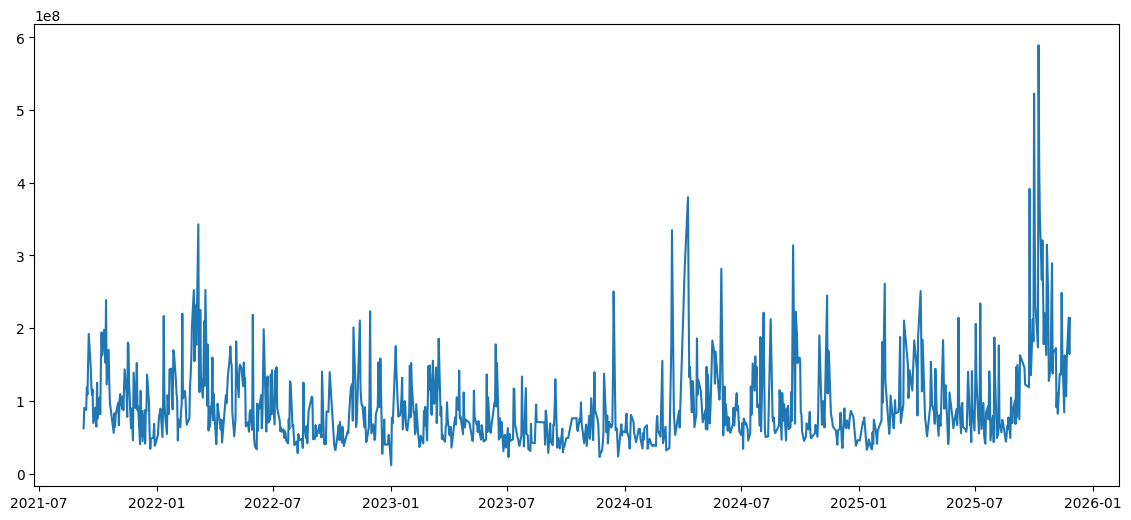

In [10]:
# check monetary difference between kgh and cla
from matplotlib import pyplot as plt
data = mock_sql_magic("select cla.date, kgh.close*kgh.volume - cla.close*cla.volume from cla join kgh on cla.date = kgh.date", return_data=True)
df = pd.DataFrame(data, columns=["date", "value_difference"])
df["date"] = pd.to_datetime(df["date"])
df = df.set_index(df["date"])
df = df.drop(columns="date")
plt.figure(figsize=(14,6))
plt.plot(df)
plt.show()

## Pandas based EDA

f:\codes\projekty\etl_finance_demo\etl_finance_demo\src\DataEDA.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs.show()


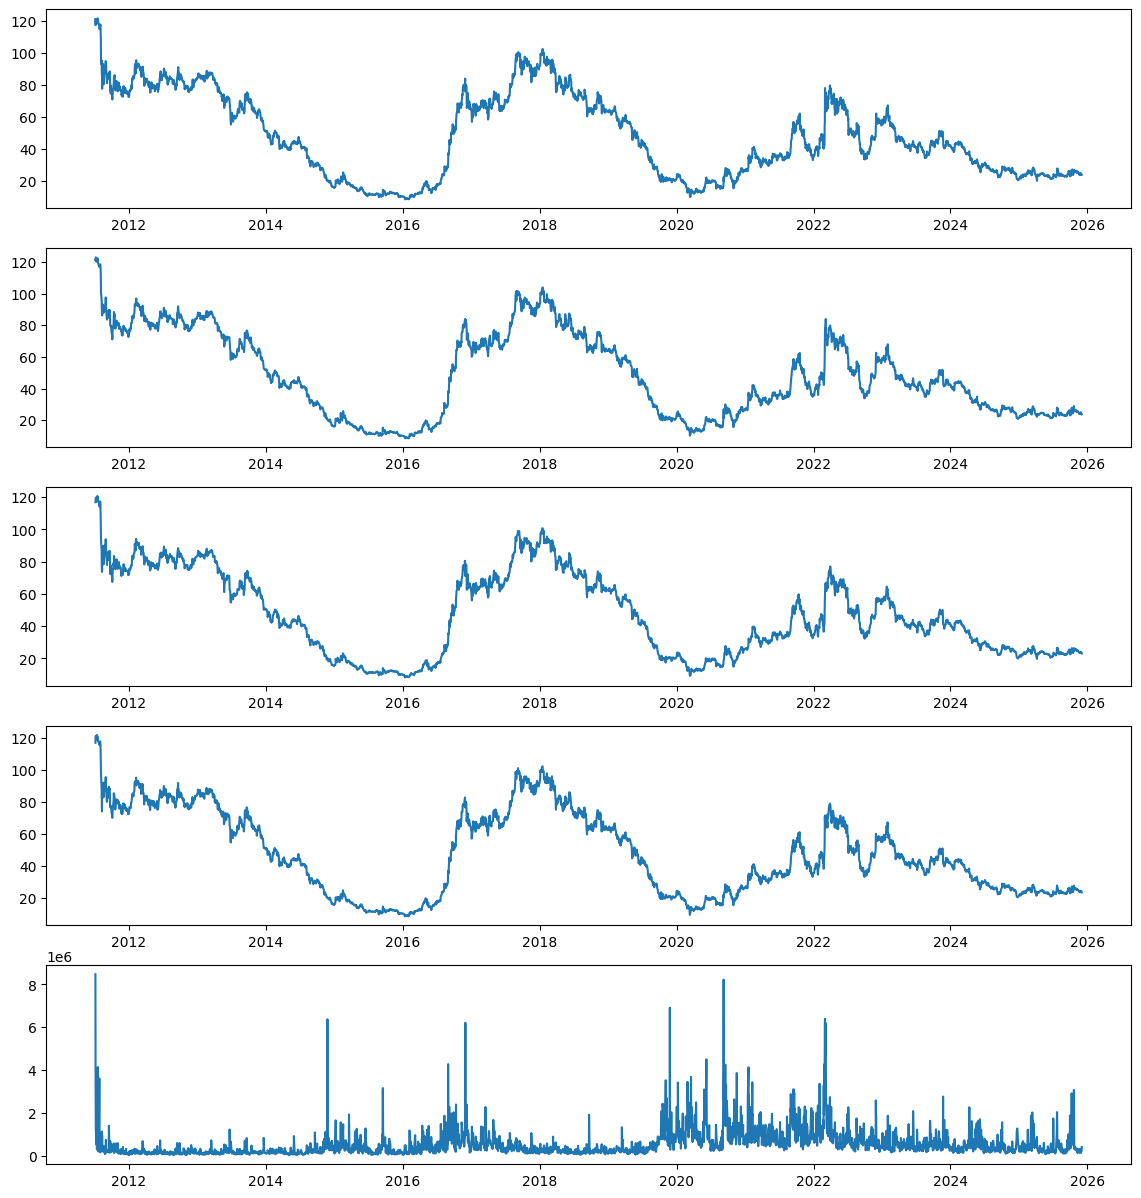

In [1]:
from src.DataEDA import DataEDA
import sqlite3
with sqlite3.connect("SQLite.db") as conn:
    eda_jsw = DataEDA(conn, "jsw")
eda_jsw.plot_ticker()

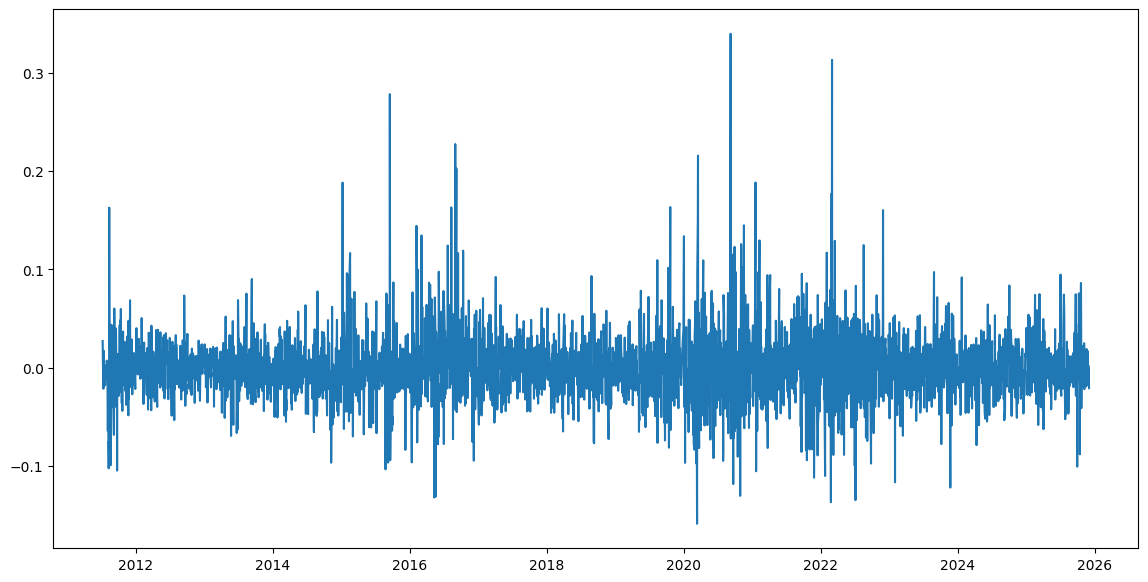

In [2]:
eda_jsw.featureEngineer.add_returns()
eda_jsw.plot_feature("returns")

checking stationary features

20.87322768974145
4.621351125938282


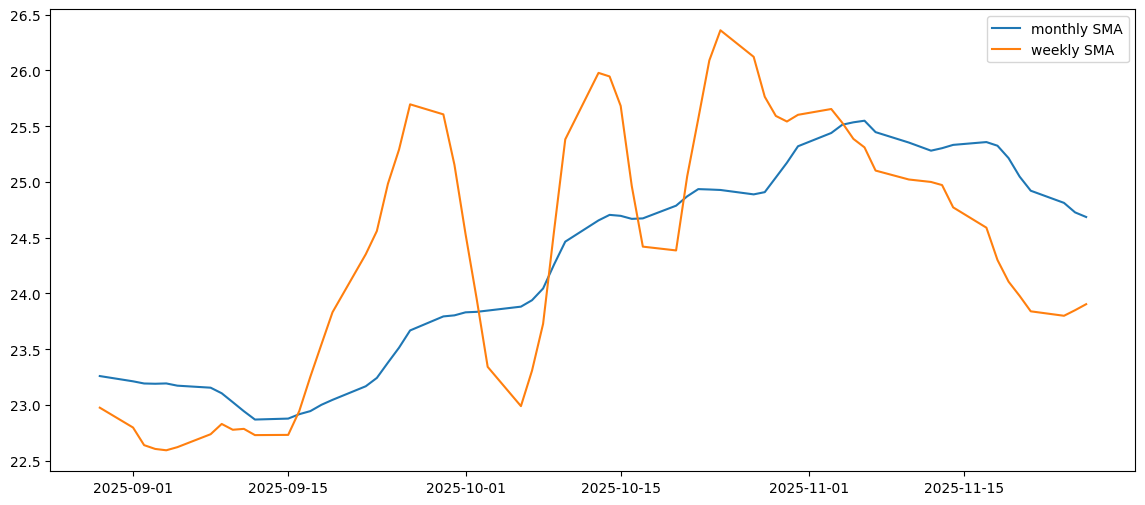

In [25]:
def add_timed_features(df):
  df["Year"] = df.index.year
  df["Month"] = df.index.month
  df["Week"] = df.index.isocalendar().week
  df["Monthly_mean_close"] = df.groupby(["Year", "Month"])["close"].transform("mean")
  print(df.groupby(["Year", "Month"])["close"].transform("count").mean()) #= 21
  print(df.groupby(["Year", "Month", "Week"])["close"].transform("count").mean()) #= 4.61
  # based on these we can set rolling metrics for week at 5 and month at 21
  trading_week_length = 5
  trading_month_length = 21
  df["Monthly_trading_days"] = df.groupby(["Year", "Month"])["close"].transform("count")
  df["SMA_weekly"] = df["close"].rolling(trading_week_length).mean()
  df["SMA_monthly"] = df["close"].rolling(trading_month_length).mean()
  df["Volatility_weekly"] = df["close"].rolling(trading_week_length).std()
  df["Volatility_monthly"] = df["close"].rolling(trading_month_length).std()
  df["Momentum_weekly"] = df["close"] - df["close"].shift(trading_week_length)
  df["Momentum_monthly"] = df["close"] - df["close"].shift(trading_month_length)
  df["EMA_weekly"] = df["close"].ewm(span = trading_week_length, adjust=False).mean()
  df["EMA_monthly"] = df["close"].ewm(span = trading_month_length, adjust=False).mean()

  df = df.drop(columns=["Year", "Month", "Week"])
  return df
df_temp = df_jsw.copy()
df_temp = add_timed_features(df_temp)
df_temp = df_temp.loc[df_temp.index > datetime.datetime.now() - datetime.timedelta(days=90)]
plt.figure(figsize=(14,6))
plt.plot(df_temp.index, df_temp["SMA_monthly"])
plt.plot(df_temp.index, df_temp["SMA_weekly"])
plt.legend(["monthly SMA", "weekly SMA"])
plt.show()